### Sentiment Analysis using Naive Bayes and K-fold Cross Validation

- Name: Chaithra Kopparam Cheluvaiah
- SUID: 326926205
- Email: ckoppara@syr.edu

### DATA

The data you will analyze in this assignment includes two .json files from the free dataset from news/message boards/blogs about CoronaVirus. This dataset has four months data – 5.2 M posts. The time frame of the data is Dec/2019 - March/2020.

Please check out the website https://ieee-dataport.org/open-access/free-dataset-newsmessage-boardsblogs-about-coronavirus-4-month-data-52m-posts for more information about this dataset.

In [ ]:
# loading required libraries
import json
import pandas as pd
import nltk
from nltk.collocations import *
from nltk.util import ngrams
import matplotlib.pyplot as plt
import math
import spacy
from nltk.tokenize import sent_tokenize
import textacy
import seaborn as sns
import numpy as np
from nltk.metrics.scores import (precision,recall,f_measure)

In [ ]:
nlp = spacy.load('en_core_web_sm')

####  LOADING DATA

In [ ]:
# importing data set
corpus_root = 'covid_data.json' # will have to replace this value with your data set file path

# data set is a json file with multiple json object hence iterating over each json object to extract the news/blogs
json_list = []
with open(corpus_root,encoding='utf8') as file_handler:
    for json_obj in file_handler:
        data = json.loads(json_obj, ecoding='utf8')
        json_list.append(data)

In [ ]:
json_list[100] # viewing single json object to understand the nodes and structure of the json

{'organizations': [],
 'uuid': '9ecfb9a8bc15fd2a2f62072835a6f853b83a053b',
 'thread': {'social': {'gplus': {'shares': 0},
   'pinterest': {'shares': 0},
   'vk': {'shares': 0},
   'linkedin': {'shares': 0},
   'facebook': {'likes': 189, 'shares': 14, 'comments': 17},
   'stumbledupon': {'shares': 0}},
  'site_full': 'nymag.com',
  'main_image': 'https://pixel.nymag.com/imgs/daily/intelligencer/2020/01/09/harris_impeachment_trial.w1200.h630.jpg',
  'site_section': 'http://feeds.feedburner.com/nymag/intelligencer',
  'section_title': 'New York Magazine -- Intelligencer',
  'url': 'http://nymag.com/intelligencer/2020/01/3-senators-on-the-grind-of-the-trump-impeachment-trial.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+nymag%2Fintelligencer+%28Intelligencer+-+New+York+Magazine%29',
  'country': 'US',
  'domain_rank': 1627,
  'title': '3 Senators on the Grind of the Trump Impeachment Trial',
  'performance_score': 0,
  'site': 'nymag.com',
  'participants_count': 1,
  'ti

In [ ]:
df = pd.DataFrame(json_list)

In [ ]:
# viewing first 5 rows to undertand the dataset
df.head()

,organizations,uuid,thread,author,url,ord_in_thread,title,locations,entities,highlightText,language,persons,text,external_links,published,crawled,highlightTitle
0,[],0ad32fb9226b172b960cba62027cd8be7d9dfa22,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Udayavani,https://m.dailyhunt.in/news/india/english/uday...,0,"Karnataka: Helplines, isolation wards set up f...",[],"{'persons': [], 'locations': [{'name': 'karnat...",,english,[],Bengaluru: Isolation wards in hospitals across...,[],2020-01-31T11:46:00.000+02:00,2020-01-31T17:18:04.007+02:00,
1,[],8c3c1e13471a5e6ef7e115588ab27f308285cf2e,"{'social': {'gplus': {'shares': 0}, 'pinterest...",,http://cnnphilippines.com/videos/2020/1/28/Hea...,0,Health dept. monitoring 24 people for possible...,[],"{'persons': [], 'locations': [{'name': 'hubei'...",,english,[],The government making sure that the new corona...,[],2020-01-28T02:00:00.000+02:00,2020-01-31T06:38:31.000+02:00,
2,[],6333601dda63a855f38435ff80ccb89b8ed8c76a,"{'social': {'gplus': {'shares': 0}, 'pinterest...",jmccorm,https://news.ycombinator.com/item?id=22194798#...,88,,[],"{'persons': [], 'locations': [], 'organization...",,english,[],Apart from more people falling sick (as bad as...,[],2020-01-31T06:38:00.000+02:00,2020-01-31T06:39:09.006+02:00,
3,[],4d639ca00ddb638ae57da43712aa50e0e56df2be,"{'social': {'gplus': {'shares': 0}, 'pinterest...",rttnews.com,https://www.rttnews.com/3064615/asian-markets-...,0,Asian Markets Mostly Higher,[],"{'persons': [{'name': 'santos', 'sentiment': '...",,english,[],Asian stock markets are mostly higher on Frida...,[],2020-01-31T05:53:00.000+02:00,2020-01-31T20:00:27.007+02:00,
4,[],624facc68c564b015fcab9a88ed7aaf8ea1e50da,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Joe Easton,http://www.bnnbloomberg.ca/tesla-soars-as-bear...,0,Tesla soars as bearish analysts left with litt...,[],"{'persons': [{'name': 'tesla', 'sentiment': 'n...",,english,[],"Cash flow was also “very strong,” at more than...",[],2020-01-30T02:00:00.000+02:00,2020-01-31T02:55:14.004+02:00,


In [ ]:
df.shape

(10956, 17)

In [ ]:
# understanding columns, column labels, column data types, null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10956 entries, 0 to 10955
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   organizations   10956 non-null  object
 1   uuid            10956 non-null  object
 2   thread          10956 non-null  object
 3   author          10956 non-null  object
 4   url             10956 non-null  object
 5   ord_in_thread   10956 non-null  int64 
 6   title           10956 non-null  object
 7   locations       10956 non-null  object
 8   entities        10956 non-null  object
 9   highlightText   10956 non-null  object
 10  language        10956 non-null  object
 11  persons         10956 non-null  object
 12  text            10956 non-null  object
 13  external_links  10956 non-null  object
 14  published       10956 non-null  object
 15  crawled         10956 non-null  object
 16  highlightTitle  10956 non-null  object
dtypes: int64(1), object(16)
memory usage: 1.4+ MB


In [ ]:
df['text'][5] # viewing text data

'CityNews catches up with arriving passengers at YVR as airlines move to cancel flights to Chinese cities in wake of the coronavirus outbreak. Jan 30, 2020, 8:49 PM Advertisement Loading ... Create a new password\nWe\'ve sent an email with instructions to create a new password. Your existing password has not been changed. We\'ll send you a link to create a new password. {* #forgotPasswordForm *} {* traditionalSignIn_emailAddress *} Thank youfor signing up!\nWe have sent a confirmation email to {* emailAddressData *} . Please check your email and click on the link to activate your account. With your existing account from {* loginWidget *} Almost Done! Please confirm the information below before signing up. {* #socialRegistrationForm *} {* socialRegistration_firstName *} {* socialRegistration_lastName *} {* socialRegistration_emailAddress *} {* socialRegistration_displayName *} By clicking "Create Account", I confirm that I have read and understood each of the website terms of service an

In [ ]:
raw_data = ' '.join(df['text'])
raw_data = raw_data.lower() # lowercase transformation

### Extract sentences that contain adjective phrases or exclamation marks or both


In [ ]:
# sentence tokenizer
sents = sent_tokenize(raw_data)
print(f'There are {len(sents)} in the corpus')

There are 232073 in the corpus


Note: There are 2 lakh sentences in the corpus. Google Colab was unable to process these many sentences. It kept crashing. hence, took sample of 1000 sentences to perform Task 1 Descriptive Statistics  

In [ ]:
sents = sents[:1000]

There are 1000 sentences in the corpus


In [ ]:
adj_phrases = []
extracted_senteces = []

In [ ]:
# extracting sentences with adjective phrases or exclamation marks or both
for sent in sents:
    doc = nlp(sent)
    adjective_pattern =[{"POS": "ADV"},{"POS": "ADJ"}] # pattern to identify adjective phrase - adverb followed by adjective
    adj_phrase = textacy.extract.matches.token_matches(doc, adjective_pattern)
    for phrase in adj_phrase:
        adj_phrases.append(phrase)  #collecting phrases
    if adj_phrase or sent.find('!'): 
        extracted_senteces.append(sent) #collecting sentences

In [ ]:
adj_phrases[:100]

[as bad,
 more fundamental,
 more dangerous,
 less stable,
 mostly higher,
 also higher,
 very strong,
 as much,
 extremely impressive,
 also lower,
 incrementally supportive,
 essentially flat,
 much cheaper,
 longer macro,
 significantly worse,
 highly bureaucratic,
 again likely,
 else right,
 most evident,
 as diverse,
 7.49pm gmt,
 7.39pm gmt,
 as many,
 newest newer,
 reportedly close,
 pretty sure,
 meanwhile former,
 very happy,
 very tough,
 out interactive,
 too few,
 too little,
 so attractive,
 previously unrecognized,
 still underway,
 now more,
 ethnically chinese,
 painfully foreign,
 ethnically chinese,
 keenly aware,
 even thicker,
 equally irrational,
 explicitly racist,
 despicably chinese,
 therefore unworthy,
 purely good,
 decidedly non,
 largely immune,
 mostly chinese,
 awfully big,
 also pro,
 overwhelmingly superior,
 largely ineffective,
 so contagious,
 just last,
 increasingly worrying,
 more infectious,
 probably easier,
 very stringent,
 more worried,
 la

In [ ]:
extracted_senteces

['bengaluru: isolation wards in hospitals across karnataka and helpline to take calls on coronavirus-related queries are ready to prevent any further spread of the virus after the first case in india was reported from kerala yesterday.',
 'the chief secretary of the state government on thursday held a meeting with the additional chief secretary (health), health commissioner, mission director of the national health mission and other health department officials and reviewed the state preparedness to tackle any cases of coronavirus whenever reported.',
 'rajiv gandhi institute of chest diseases (rgicd) with 15 beds and wenlock hospital at mangaluru with 10 beds have been selected for the treatment of the virus.',
 'all district hospitals will have five beds isolated for patients carrying the virus.',
 'along with this, at least ten private hospitals in bengaluru will be setting up similar isolation wards.',
 'the national institute of virology and the viral research and diagnostic laborat

## TASK 1 - DESCRIPTIVE STATISTICS (on extracted sentences)

- average length of a sentence
- top 50 adjective phrases (by frequency)
- top 50 adjective words
- top 50 nouns
- top 50 bigrams that contain adjective/nouns/verbs

#### AVERAGE LENGTH OF A SENTENCE

In [ ]:
temp_tokens = nltk.word_tokenize(''.join(extracted_senteces))
avglen_sent = len(temp_tokens)/len(sents)
print(f'average length of a sentence = {avglen_sent}')

# 25.424 words per sentence on average

average length of a sentence = 25.424


#### TOP 50 ADJECTIVE PHRASES (by frequency)

In [ ]:
phrase_freq = nltk.FreqDist(adj_phrases)
phrase_freq.most_common(50)

[(as bad, 1),
 (more fundamental, 1),
 (more dangerous, 1),
 (less stable, 1),
 (mostly higher, 1),
 (also higher, 1),
 (very strong, 1),
 (as much, 1),
 (extremely impressive, 1),
 (also lower, 1),
 (incrementally supportive, 1),
 (essentially flat, 1),
 (much cheaper, 1),
 (longer macro, 1),
 (significantly worse, 1),
 (highly bureaucratic, 1),
 (again likely, 1),
 (else right, 1),
 (most evident, 1),
 (as diverse, 1),
 (7.49pm gmt, 1),
 (7.39pm gmt, 1),
 (as many, 1),
 (newest newer, 1),
 (reportedly close, 1),
 (pretty sure, 1),
 (meanwhile former, 1),
 (very happy, 1),
 (very tough, 1),
 (out interactive, 1),
 (too few, 1),
 (too little, 1),
 (so attractive, 1),
 (previously unrecognized, 1),
 (still underway, 1),
 (now more, 1),
 (ethnically chinese, 1),
 (painfully foreign, 1),
 (ethnically chinese, 1),
 (keenly aware, 1),
 (even thicker, 1),
 (equally irrational, 1),
 (explicitly racist, 1),
 (despicably chinese, 1),
 (therefore unworthy, 1),
 (purely good, 1),
 (decidedly non,

#### TOP 50 ADJECTIVE WORDS

In [ ]:
# removing punctuation and numeric values so that we get meaningful ajective words and nouns
revised_tokens = [token for token in temp_tokens if token.isalpha()]

In [ ]:
tagged = nltk.pos_tag(revised_tokens) #resource intense

In [ ]:
# identifying all the adjectives
# JJ	This NLTK POS Tag is an adjective (large)
# JJR	adjective, comparative (larger)
# JJS	adjective, superlative (largest)

adjectives = [token for token, tag in tagged if tag in ['JJ','JJR','JJS']] 
freq = nltk.FreqDist(adjectives)
freq.most_common(50)

[('chinese', 104),
 ('new', 61),
 ('more', 43),
 ('global', 41),
 ('first', 39),
 ('international', 33),
 ('other', 28),
 ('s', 28),
 ('public', 24),
 ('last', 22),
 ('national', 20),
 ('wuhan', 18),
 ('january', 18),
 ('united', 16),
 ('medical', 15),
 ('i', 15),
 ('novel', 15),
 ('canadian', 14),
 ('close', 13),
 ('due', 13),
 ('british', 13),
 ('asian', 12),
 ('such', 12),
 ('gmt', 11),
 ('social', 11),
 ('similar', 10),
 ('deadly', 10),
 ('high', 10),
 ('uk', 10),
 ('infectious', 10),
 ('further', 9),
 ('next', 9),
 ('positive', 9),
 ('recent', 9),
 ('friday', 9),
 ('past', 9),
 ('current', 9),
 ('many', 9),
 ('good', 9),
 ('local', 9),
 ('infected', 9),
 ('former', 9),
 ('thursday', 8),
 ('few', 8),
 ('official', 8),
 ('second', 8),
 ('china', 8),
 ('potential', 8),
 ('severe', 8),
 ('able', 8)]

#### TOP 50 NOUNS

In [ ]:
# identifying all the nouns
#NN	noun, singular (cat, tree)
#NNS	noun plural (desks)
#NNP	proper noun, singular (sarah)
#NNPS	proper noun, plural (indians or americans)

nouns = [token for token, tag in tagged if tag in ['NN','NNS','NNP','NNPS']]
freq = nltk.FreqDist(nouns)
freq.most_common(50)

[('coronavirus', 127),
 ('health', 108),
 ('china', 101),
 ('virus', 80),
 ('people', 78),
 ('s', 54),
 ('cases', 50),
 ('outbreak', 44),
 ('world', 37),
 ('emergency', 36),
 ('loan', 35),
 ('spread', 34),
 ('travel', 34),
 ('man', 31),
 ('case', 30),
 ('country', 29),
 ('i', 29),
 ('news', 28),
 ('market', 25),
 ('countries', 25),
 ('facebook', 25),
 ('week', 24),
 ('gmt', 24),
 ('city', 23),
 ('twitter', 23),
 ('wuhan', 22),
 ('hospital', 21),
 ('cent', 21),
 ('contact', 21),
 ('disease', 20),
 ('video', 20),
 ('club', 20),
 ('number', 19),
 ('risk', 19),
 ('government', 18),
 ('flights', 18),
 ('time', 18),
 ('sars', 18),
 ('home', 18),
 ('organization', 17),
 ('staff', 17),
 ('officials', 16),
 ('concern', 16),
 ('season', 16),
 ('deal', 16),
 ('impact', 16),
 ('markets', 15),
 ('part', 15),
 ('statement', 15),
 ('person', 15)]

#### TOP 50 BIGRAMS THAT CONTAIN ADJECTIVE/NOUNS/VERBS

In [ ]:
tagged_tokens = nltk.pos_tag(temp_tokens)

In [ ]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tagged_tokens)
word_tag_pair = finder.score_ngrams(bigram_measures.raw_freq)

In [ ]:
# filtering bigrams with all the nouns, adjectives, and verbs
rev_bigrams = []
for pair in word_tag_pair: 
    if pair[0][0][1].startswith('N') or pair[0][0][1].startswith('JJ') or pair[0][0][1].startswith('V') or pair[0][1][1].startswith('N') or pair[0][1][1].startswith('JJ') or pair[0][1][1].startswith('V'):
        rev_bigrams.append(pair)

In [ ]:
rev_bigrams[:50]

[((('the', 'DT'), ('virus', 'NN')), 0.0020059786028949022),
 ((('’', 'NNP'), ('s', 'NN')), 0.0018879798615481435),
 ((('the', 'DT'), ('coronavirus', 'NN')), 0.0014553178099433607),
 ((('the', 'DT'), ('chinese', 'JJ')), 0.0013766519823788547),
 ((('to', 'TO'), ('be', 'VB')), 0.0012979861548143487),
 ((('the', 'DT'), ('world', 'NN')), 0.0012193203272498428),
 ((('have', 'VBP'), ('been', 'VBN')), 0.0011799874134675898),
 ((('in', 'IN'), ('china', 'NN')), 0.0009833228445563246),
 ((('spread', 'NN'), ('of', 'IN')), 0.0009439899307740718),
 ((('the', 'DT'), ('outbreak', 'NN')), 0.0009439899307740718),
 ((('to', 'TO'), ('china', 'VB')), 0.0009439899307740718),
 ((('will', 'MD'), ('be', 'VB')), 0.0009439899307740718),
 ((('china', 'NN'), (',', ',')), 0.0009046570169918188),
 ((('from', 'IN'), ('china', 'NN')), 0.0009046570169918188),
 ((('more', 'JJR'), ('than', 'IN')), 0.0009046570169918188),
 ((('on', 'IN'), ('loan', 'NN')), 0.0009046570169918188),
 ((('the', 'DT'), ('first', 'JJ')), 0.00090

## TASK 2 - SENTIMENT POLARITY

In [ ]:
# using twitter dataset from kaggle https://www.kaggle.com/crowdflower/twitter-airline-sentiment for training the model

# reasons for choosing twitter dataset for training the model:
# 1) more categories for predicting sentiment polarity of news articles. 
# tweets data in the kaggle had three polarities - negative, positive, and neutral
# 2) tweets are mostly related to news discussion so it would be appropriate to train the model with twitter data for our news corpus


tweetsdf = pd.read_csv('Tweets.zip')
tweetsdf.shape

(14640, 15)

In [ ]:
tweetsdf.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
tweetsdf['text'] = tweetsdf['text'].apply(str.lower) # lowercase transformation

In [ ]:
tweetsdf['text']

0                      @virginamerica what @dhepburn said.
1        @virginamerica plus you've added commercials t...
2        @virginamerica i didn't today... must mean i n...
3        @virginamerica it's really aggressive to blast...
4        @virginamerica and it's a really big bad thing...
                               ...                        
14635    @americanair thank you we got on a different f...
14636    @americanair leaving over 20 minutes late flig...
14637    @americanair please bring american airlines to...
14638    @americanair you have my money, you change my ...
14639    @americanair we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [ ]:
# removing twitter name tags
tweetsdf['clean_text'] = tweetsdf['text'].str.replace('(@\w+.*?)',"")

C:\Users\Chaithra\AppData\Local\Temp/ipykernel_27304/1558546787.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweetsdf['clean_text'] = tweetsdf['text'].str.replace('(@\w+.*?)',"")


In [ ]:
# removing twitter hash tags
tweetsdf['clean_text'] = tweetsdf['clean_text'].str.replace('(#\w+.*?)',"")

C:\Users\Chaithra\AppData\Local\Temp/ipykernel_27304/1904228228.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweetsdf['clean_text'] = tweetsdf['clean_text'].str.replace('(#\w+.*?)',"")


In [ ]:
tweetsdf['clean_text']

0                                              what  said.
1         plus you've added commercials to the experien...
2         i didn't today... must mean i need to take an...
3         it's really aggressive to blast obnoxious "en...
4                 and it's a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to chi...
14636     leaving over 20 minutes late flight. no warni...
14637                   please bring american airlines to 
14638     you have my money, you change my flight, and ...
14639     we have 8 ppl so we need 2 know how many seat...
Name: clean_text, Length: 14640, dtype: object

In [ ]:
# Unique values of sentiment
tweetsdf['airline_sentiment'].unique()


array(['neutral', 'positive', 'negative'], dtype=object)

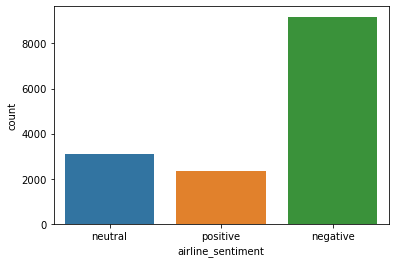

In [ ]:
# Unique values of sentiment plot
ax = sns.countplot(x="airline_sentiment", data=tweetsdf)

Positive and neutral tweets are almost equal.

Negative tweets are more than double of neutral or positive sentiments.

In [ ]:
tweetsdf['tokenized_text'] = tweetsdf['clean_text'].apply(nltk.word_tokenize)

In [ ]:
tweetsdf['combine'] = tweetsdf[["tokenized_text","airline_sentiment"]].apply(tuple, axis=1)

In [ ]:
# creating documents of twitter text and its sentiment
documents = tweetsdf['combine'].tolist()

In [ ]:
print(documents[0])
print(documents[-1])

(['what', 'said', '.'], 'neutral')
(['we', 'have', '8', 'ppl', 'so', 'we', 'need', '2', 'know', 'how', 'many', 'seats', 'are', 'on', 'the', 'next', 'flight', '.', 'plz', 'put', 'us', 'on', 'standby', 'for', '4', 'people', 'on', 'the', 'next', 'flight', '?'], 'neutral')


In [ ]:
import random
# Since the documents are in order by label, we mix them up for later separation into training and test sets.
random.shuffle(documents)

In [ ]:
#### Bag of Words

# We need to define the set of words that will be used for features.  
# This is essentially all the words in the entire document collection, 
# except that we will limit it to 4000 most frequent words.  

all_words_list = [word for (sent,cat) in documents for word in sent]
all_words = nltk.FreqDist(all_words_list)

# get the  most frequently appearing keywords in the corpus
word_items = all_words.most_common(4000)
word_features = [word for (word,count) in word_items]
print(word_features[:50])

['.', 'to', 'i', 'the', '!', '?', 'a', 'you', ',', 'for', 'flight', 'on', 'and', 'my', 'is', 'in', 'it', 'of', "n't", ':', 'me', 'your', 'have', 'that', 'was', 'not', 'with', "'s", 'no', 'at', 'this', 'do', 'get', 'we', 'but', 'be', 'from', 'can', 'http', 'are', 'thanks', '...', 'cancelled', 'now', 'an', 'just', ';', 'service', 'so', 'been']


In [ ]:
# creating document features
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

In [ ]:
# features sets for a document, including keyword features and the sentiment
featuresets = [(document_features(d), c) for (d, c) in documents]

In [ ]:
featuresets[0]

({'.': True,
  'to': False,
  'i': False,
  'the': False,
  '!': False,
  '?': False,
  'a': False,
  'you': False,
  ',': False,
  'for': False,
  'flight': False,
  'on': True,
  'and': False,
  'my': False,
  'is': True,
  'in': False,
  'it': False,
  'of': False,
  "n't": False,
  ':': True,
  'me': False,
  'your': False,
  'have': False,
  'that': True,
  'was': False,
  'not': False,
  'with': False,
  "'s": True,
  'no': False,
  'at': False,
  'this': False,
  'do': False,
  'get': False,
  'we': False,
  'but': False,
  'be': False,
  'from': False,
  'can': False,
  'http': True,
  'are': False,
  'thanks': False,
  '...': False,
  'cancelled': False,
  'now': True,
  'an': False,
  'just': False,
  ';': True,
  'service': False,
  'so': False,
  'been': False,
  'help': False,
  '&': True,
  'what': False,
  'time': False,
  'will': False,
  'they': False,
  'customer': False,
  'up': False,
  '-': False,
  'out': False,
  'our': True,
  "'m": False,
  'amp': False,
  ')':

In [ ]:
len(featuresets)

14640

In [ ]:
# training using naive Baysian classifier, training set is approximately 60% of data
train_set,testsets = featuresets[:8784], featuresets[8784:]
classifier1 = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
#### MODEL EVALUATION - ACCURACY, PRECISION, RECALL, and F1 SCORE

test_result = []
gold_result = []

for i in range(len(testsets)):
    test_result.append(classifier1.classify(testsets[i][0])) # predicted
    gold_result.append(testsets[i][1]) # already labelled

confusion_matrix = nltk.ConfusionMatrix(gold_result, test_result)
print(confusion_matrix)

from sklearn.metrics import classification_report

print(classification_report(gold_result, test_result))

         |    n         p |
         |    e    n    o |
         |    g    e    s |
         |    a    u    i |
         |    t    t    t |
         |    i    r    i |
         |    v    a    v |
         |    e    l    e |
---------+----------------+
negative |<3122> 348  198 |
 neutral |  298 <790> 166 |
positive |  143  104 <687>|
---------+----------------+
(row = reference; col = test)

              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      3668
     neutral       0.64      0.63      0.63      1254
    positive       0.65      0.74      0.69       934

    accuracy                           0.79      5856
   macro avg       0.72      0.74      0.73      5856
weighted avg       0.79      0.79      0.79      5856



In [ ]:
classifier1.show_most_informative_features(30)

Most Informative Features
                   hours = True           negati : positi =     37.4 : 1.0
                 worries = True           positi : negati =     37.3 : 1.0
                   kudos = True           positi : negati =     34.7 : 1.0
                   enjoy = True           positi : negati =     29.5 : 1.0
               beautiful = True           positi : negati =     27.0 : 1.0
                  street = True           neutra : negati =     26.9 : 1.0
                 appease = True           neutra : negati =     24.9 : 1.0
                 awesome = True           positi : negati =     24.5 : 1.0
                 welcome = True           positi : negati =     24.4 : 1.0
                   thank = True           positi : negati =     24.1 : 1.0
                    wall = True           neutra : negati =     23.3 : 1.0
                 battles = True           neutra : negati =     22.9 : 1.0
                   raise = True           positi : negati =     21.8 : 1.0

#### MODEL 2: REMOVING PUNCTUATIONS, STOP WORDS, LEMMATIZATION TO IMPROVE THE ACCURACY OF THE MODEL

In [ ]:
# converting raw data to nltk.Text
nltk_stops = nltk.corpus.stopwords.words('english')

def preprocessing(text):
    text = [token for token in text if token.isalpha()] # removing punctuations
    text = [token for token in text if token not in nltk_stops] # removing stop words
    text = [nlp(token)[0].lemma_ for token in text] # lemmatization
    return text

In [ ]:
# random Sampling
N=2300
sample_df = tweetsdf.groupby('airline_sentiment', group_keys=False).apply(lambda x: x.sample(N))

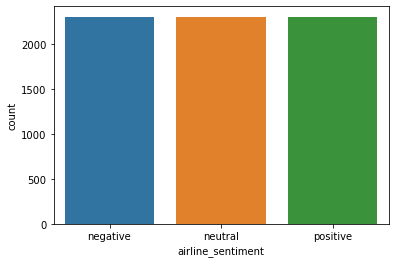

In [ ]:
# Unique values of sentiment plot
ax = sns.countplot(x="airline_sentiment", data=sample_df)

In [ ]:
sample_df['revised_text'] = sample_df['tokenized_text'].apply(preprocessing)

In [ ]:
sample_df['combined_rev'] = sample_df[["revised_text","airline_sentiment"]].apply(tuple, axis=1)

In [ ]:
documents_rev = sample_df['combined_rev'].tolist()

print(documents_rev[0])
print(documents_rev[-1])

(['six', 'hour', 'even', 'gate', 'agent', 'get', 'feed', 'leave', 'we', 'line', 'front', 'empty', 'desk', 'stay', 'classy', 'we', 'air'], 'negative')
(['love', 'guy', 'sooooooo', 'much', 'ridiculously', 'appreciate', 'service'], 'positive')


In [ ]:
#### Bag of Words

# Since the documents are in order by label, we mix them up for later separation into training and test sets.
random.shuffle(documents_rev)

# We need to define the set of words that will be used for features.  
# This is essentially all the words in the entire document collection, 
# except that we will limit it to the 4000 most frequent words.  

all_words_list_rev = [word for (sent,cat) in documents_rev for word in sent]
all_words_rev = nltk.FreqDist(all_words_list)

# get the 4000 most frequently appearing keywords in the corpus
word_items_rev = all_words_rev.most_common(4000)
word_features_rev = [word for (word,count) in word_items]
print(word_features_rev[:50])

['.', 'to', 'i', 'the', '!', '?', 'a', 'you', ',', 'for', 'flight', 'on', 'and', 'my', 'is', 'in', 'it', 'of', "n't", ':', 'me', 'your', 'have', 'that', 'was', 'not', 'with', "'s", 'no', 'at', 'this', 'do', 'get', 'we', 'but', 'be', 'from', 'can', 'http', 'are', 'thanks', '...', 'cancelled', 'now', 'an', 'just', ';', 'service', 'so', 'been']


In [ ]:
import random
# Since the documents are in order by label, we mix them up for later separation into training and test sets.
random.shuffle(documents_rev)


# Task 3: sentiment classification 
def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features[word] = (word in document_words)
    return features

# get features sets for a document, including keyword features and category feature
featuresets_rev = [(document_features(d), c) for (d, c) in documents_rev]

In [ ]:
len(featuresets_rev)

6900

In [ ]:
# training using naive Baysian classifier, training set is approximately 60% of data
train_set_rev,testsets_rev = featuresets_rev[:4140], featuresets_rev[4140:]
classifier3 = nltk.NaiveBayesClassifier.train(train_set_rev)

In [ ]:
#### MODEL EVALUATION - ACCURACY, PRECISION, RECALL, and F1 SCORE
test_result_rev = []
gold_result_rev = []

for i in range(len(testsets_rev)):
    test_result_rev.append(classifier3.classify(testsets_rev[i][0])) # predicted
    gold_result_rev.append(testsets_rev[i][1]) # already labelled

In [ ]:
confusion_matrix_rev = nltk.ConfusionMatrix(gold_result_rev, test_result_rev)
print(confusion_matrix_rev)

         |   n       p |
         |   e   n   o |
         |   g   e   s |
         |   a   u   i |
         |   t   t   t |
         |   i   r   i |
         |   v   a   v |
         |   e   l   e |
---------+-------------+
negative |<643>168 106 |
 neutral | 165<596>156 |
positive |  92 137<697>|
---------+-------------+
(row = reference; col = test)



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(gold_result_rev, test_result_rev))

              precision    recall  f1-score   support

    negative       0.71      0.70      0.71       917
     neutral       0.66      0.65      0.66       917
    positive       0.73      0.75      0.74       926

    accuracy                           0.70      2760
   macro avg       0.70      0.70      0.70      2760
weighted avg       0.70      0.70      0.70      2760



In [ ]:
classifier3.show_most_informative_features(30)

Most Informative Features
                 amazing = True           positi : negati =     29.9 : 1.0
                   great = True           positi : neutra =     24.6 : 1.0
                 awesome = True           positi : neutra =     21.5 : 1.0
                    hour = True           negati : positi =     17.7 : 1.0
                  always = True           positi : neutra =     17.1 : 1.0
                    rock = True           positi : neutra =     16.4 : 1.0
                    suck = True           negati : neutra =     15.7 : 1.0
                  online = True           negati : positi =     14.2 : 1.0
                    hold = True           negati : positi =     14.0 : 1.0
                 helpful = True           positi : neutra =     13.8 : 1.0
                   hotel = True           negati : neutra =     13.7 : 1.0
                     hrs = True           negati : neutra =     13.4 : 1.0
              experience = True           negati : neutra =     13.0 : 1.0

#### MODEL 3: MULTI FOLD CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

# 10 folds
splits = 10
kf = KFold(n_splits=splits)
total = 0
for train, test in kf.split(featuresets):
    train_data = np.array(featuresets)[train]
    test_data = np.array(featuresets)[test]
    classifier2 = nltk.NaiveBayesClassifier.train(train_data)
    total += nltk.classify.accuracy(classifier2, test_data)
average = total/splits # average accuracy of all the folds

In [ ]:
round(average*100) # accuracy of the 10-fold model

78

External Reference: https://thelillysblog.com/2017/08/18/machine-learning-k-fold-validation/

#### PREDICTING SENTIMENT POLARITY OF THE NEWS ARTICLES

Note: Predicting the sentiment score for 2 lakh senteces in the corpus is resource intense and was unable to perform. Google Colab kept crashing. Hence, predicted the sentiment polarity of 200 articles from the cropus

In [ ]:
df['text'] = df['text'].apply(str.lower) # applying lower transformation
tempdf = df.iloc[:200]

# iterating over each news article to predict the sentiment
for index,row in tempdf.iterrows():
    sents = nltk.sent_tokenize(row['text'])
    num_pos_score = 0
    num_neg_score = 0
    num_neutral_score = 0
    pos_sents = []
    neg_sents = []
    neutral_sents = []
    for sent in sents:
        testing_data = document_features(nltk.word_tokenize(sent))
        score = classifier2.classify(testing_data) # predicting the sentiment
        if score == 'positive':
            num_pos_score = num_pos_score + 1
            pos_sents.append(sent)
        elif score == 'negative':
            num_neg_score = num_neg_score + 1
            neg_sents.append(sent)
        elif score == 'neutral':
            num_neutral_score = num_neutral_score + 1
            neutral_sents.append(sent)
            
    tempdf.loc[index, 'the number of positive sentences'] = num_pos_score
    tempdf.loc[index, 'the number of negative sentences'] = num_neg_score
    tempdf.loc[index, 'the number of neutral sentences'] = num_neutral_score
    tempdf.loc[index, 'positive sentences'] = ''.join(pos_sents)
    tempdf.loc[index, 'negative sentences'] = ''.join(neg_sents)
    tempdf.loc[index, 'neutral sentences'] = ''.join(neutral_sents)

In [ ]:
tempdf

,organizations,uuid,thread,author,url,ord_in_thread,title,locations,entities,highlightText,...,external_links,published,crawled,highlightTitle,the number of positive sentences,the number of negative sentences,the number of neutral sentences,positive sentences,negative sentences,neutral sentences
0,[],0ad32fb9226b172b960cba62027cd8be7d9dfa22,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Udayavani,https://m.dailyhunt.in/news/india/english/uday...,0,"Karnataka: Helplines, isolation wards set up f...",[],"{'persons': [], 'locations': [{'name': 'karnat...",,...,[],2020-01-31T11:46:00.000+02:00,2020-01-31T17:18:04.007+02:00,,2.0,3.0,3.0,all district hospitals will have five beds iso...,bengaluru: isolation wards in hospitals across...,the chief secretary of the state government on...
1,[],8c3c1e13471a5e6ef7e115588ab27f308285cf2e,"{'social': {'gplus': {'shares': 0}, 'pinterest...",,http://cnnphilippines.com/videos/2020/1/28/Hea...,0,Health dept. monitoring 24 people for possible...,[],"{'persons': [], 'locations': [{'name': 'hubei'...",,...,[],2020-01-28T02:00:00.000+02:00,2020-01-31T06:38:31.000+02:00,,0.0,2.0,1.0,,the government making sure that the new corona...,"aside from monitoring suspected cases, authori..."
2,[],6333601dda63a855f38435ff80ccb89b8ed8c76a,"{'social': {'gplus': {'shares': 0}, 'pinterest...",jmccorm,https://news.ycombinator.com/item?id=22194798#...,88,,[],"{'persons': [], 'locations': [], 'organization...",,...,[],2020-01-31T06:38:00.000+02:00,2020-01-31T06:39:09.006+02:00,,0.0,1.0,1.0,,apart from more people falling sick (as bad as...,"as infections climb, the coronavirus (based on..."
3,[],4d639ca00ddb638ae57da43712aa50e0e56df2be,"{'social': {'gplus': {'shares': 0}, 'pinterest...",rttnews.com,https://www.rttnews.com/3064615/asian-markets-...,0,Asian Markets Mostly Higher,[],"{'persons': [{'name': 'santos', 'sentiment': '...",,...,[],2020-01-31T05:53:00.000+02:00,2020-01-31T20:00:27.007+02:00,,3.0,7.0,11.0,"among the major miners, fortescue metals is ad...",the benchmark s&p/asx 200 index is adding 27.8...,asian stock markets are mostly higher on frida...
4,[],624facc68c564b015fcab9a88ed7aaf8ea1e50da,"{'social': {'gplus': {'shares': 0}, 'pinterest...",Joe Easton,http://www.bnnbloomberg.ca/tesla-soars-as-bear...,0,Tesla soars as bearish analysts left with litt...,[],"{'persons': [{'name': 'tesla', 'sentiment': 'n...",,...,[],2020-01-30T02:00:00.000+02:00,2020-01-31T02:55:14.004+02:00,,2.0,15.0,6.0,"however, on a reasonable base case, still beli...","cash flow was also “very strong,” at more than...",jonas is among 18 analysts surveyed that have ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,[],df347af749dd4e3ab0a308a1f6c8004828b10621,"{'social': {'gplus': {'shares': 0}, 'pinterest...",indiatimes.com,https://timesofindia.indiatimes.com/business/i...,0,Coronavirus: Air India special flight to take ...,[],"{'persons': [{'name': 'saurabh sinha', 'sentim...",,...,"[https://t.co/YgZH4935LM, https://twitter.com/...",2020-01-31T06:17:00.000+02:00,2020-01-31T08:09:49.035+02:00,,0.0,2.0,1.0,,this article was originally published on this ...,post views: 2
196,[],817eca2a01f78eefab565a6472498b663cc1bb84,"{'social': {'gplus': {'shares': 0}, 'pinterest...",info@dailyforex.com,https://www.dailyforex.com/forex-technical-ana...,0,GBP/USD Technical Analysis: Cautious Anticipat...,[],"{'persons': [{'name': 'mark carney', 'sentimen...",,...,[https://twitter.com/share?url=http://dailyfor...,2020-01-30T15:36:00.000+02:00,2020-01-31T14:51:30.000+02:00,,2.0,9.0,9.0,advertisement trade now according to the techn...,gbp/usd technical analysis: cautious anticipat...,"the fed, as expected, kept interest rates unch..."
197,[],ef532589c4ec9c8c1dd608069ed6c701d5540140,"{'social': {'gplus': {'shares': 0}, 'pinterest...",,https://www.sharenet.co.za/news/Companies_in_B...,0,Companies in Beijing to resume work on Feb 10 ...,[],"{'persons': [{'name': 'jason neely', 'sentimen...",,...,[],2020-01

In [ ]:
# writing the output to csv
tempdf.to_csv('model_predictions.csv')

In [ ]:
# pos tagging of sentences
def top_postags(sents,req_tag,n=50):
    sents = ''.join(sents)
    tokens = nltk.word_tokenize(sents)
    tagged_tokens = nltk.pos_tag(tokens)
    adjectives = [token for token, tag in tagged_tokens if tag.startswith(req_tag)]
    freq = nltk.FreqDist(adjectives)
    return freq.most_common(n)

#### TOP 50 ADJECTIVE ADVERB VERBS OF POSITIVE SENTENCES

In [ ]:
top_postags(tempdf['positive sentences'],'JJ') # adjectives

[('chinese', 30),
 ('global', 20),
 ('new', 19),
 ('last', 11),
 ('other', 10),
 ('major', 9),
 ('such', 9),
 ('positive', 8),
 ('high', 7),
 ('–', 7),
 ('former', 7),
 ('first', 7),
 ('many', 7),
 ('more', 6),
 ('good', 6),
 ('great', 6),
 ('national', 6),
 ('similar', 5),
 ('international', 5),
 ('u.s.', 5),
 ('south', 5),
 ('epidemic', 5),
 ('viral', 5),
 ('daily', 5),
 ('next', 4),
 ('further', 4),
 ('united', 4),
 ('several', 4),
 ('s', 4),
 ('foreign', 4),
 ('novel', 4),
 ('few', 4),
 ('thursday', 4),
 ('social', 4),
 ('annual', 4),
 ('european', 4),
 ('likely', 4),
 ('impressive', 4),
 ('immediate', 4),
 ('bad', 4),
 ('suitable', 4),
 ('least', 3),
 ('private', 3),
 ('higher', 3),
 ('weak', 3),
 ('us-china', 3),
 ('lower', 3),
 ('shanghai', 3),
 ('free', 3),
 ('january', 3)]

In [ ]:
top_postags(tempdf['positive sentences'],'RB') # adverbs

[('also', 21),
 ('not', 16),
 ('so', 10),
 ('just', 9),
 ('always', 9),
 ('now', 8),
 ('forward', 7),
 ('very', 7),
 ('back', 7),
 ('well', 6),
 ('first', 5),
 ('already', 5),
 ('earlier', 4),
 ('even', 4),
 ('particularly', 4),
 ('effectively', 4),
 ('as', 4),
 ('too', 4),
 ('quickly', 3),
 ('more', 3),
 ('far', 3),
 ('s', 3),
 ('later', 3),
 ('however', 3),
 ('still', 2),
 ('safely', 2),
 ('once', 2),
 ('ahead', 2),
 ('mostly', 2),
 ('down', 2),
 ('highly', 2),
 ('personally', 2),
 ('eventually', 2),
 ('relatively', 2),
 ('mat', 2),
 ('especially', 2),
 ('therefore', 2),
 ('much', 2),
 ('closely', 2),
 ('sometimes', 2),
 ('overnight.however', 1),
 ('reportedly', 1),
 ('close', 1),
 ('leipzig', 1),
 ('here', 1),
 ('steven', 1),
 ('little', 1),
 ('tax.awfully', 1),
 ('finally', 1),
 ('only', 1)]

In [ ]:
top_postags(tempdf['positive sentences'],'VB') # verbs

[('is', 55),
 ('are', 51),
 ('was', 44),
 ('has', 42),
 ('have', 35),
 ('said', 27),
 ('be', 25),
 ('were', 22),
 ('had', 18),
 ('been', 15),
 ('reported', 13),
 ('“', 13),
 ('’', 11),
 ('being', 10),
 ('made', 9),
 ('found', 8),
 ("'s", 8),
 ('including', 8),
 ('s', 7),
 ('working', 7),
 ('makes', 7),
 ('tested', 7),
 ('brought', 6),
 ('”', 6),
 ('united', 5),
 ('set', 5),
 ('say', 5),
 ('getting', 5),
 ('spreading', 5),
 ('declared', 5),
 ('taken', 5),
 ('see', 5),
 ('isolated', 4),
 ('believes', 4),
 ('declined', 4),
 ('signing', 4),
 ('urged', 4),
 ('wants', 4),
 ('released', 4),
 ('make', 4),
 ('told', 4),
 ('wish', 4),
 ('keep', 4),
 ('wearing', 4),
 ('gets', 4),
 ('done', 4),
 ('find', 4),
 ('doing', 4),
 ('charging', 4),
 ('did', 4)]

#### TOP 50 ADJECTIVE ADVERB VERBS OF NEGATIVE SENTENCES

In [ ]:
top_postags(tempdf['negative sentences'],'JJ') # adjectives

[('chinese', 187),
 ('new', 156),
 ('more', 136),
 ('other', 109),
 ('first', 83),
 ('global', 76),
 ('medical', 73),
 ('public', 66),
 ('international', 56),
 ('least', 55),
 ('’', 50),
 ('last', 50),
 ('many', 46),
 ('due', 45),
 ('such', 44),
 ('s', 41),
 ('january', 41),
 ('united', 40),
 ('u.s.', 40),
 ('economic', 37),
 ('“', 34),
 ('next', 34),
 ('close', 33),
 ('british', 33),
 ('american', 32),
 ('confirmed', 32),
 ('central', 32),
 ('same', 31),
 ('novel', 31),
 ('further', 30),
 ('high', 30),
 ('i', 30),
 ('local', 30),
 ('wuhan', 29),
 ('past', 28),
 ('major', 28),
 ('several', 28),
 ('getty', 28),
 ('national', 27),
 ('current', 25),
 ('human', 24),
 ('chief', 23),
 ('deadly', 23),
 ('canadian', 23),
 ('few', 23),
 ('big', 23),
 ('likely', 23),
 ('good', 22),
 ('latest', 22),
 ('severe', 22)]

In [ ]:
top_postags(tempdf['negative sentences'],'RB') # adverb

[('not', 234),
 ('also', 135),
 ('now', 110),
 ('more', 57),
 ('so', 57),
 ("n't", 56),
 ('even', 51),
 ('still', 49),
 ('only', 47),
 ('just', 46),
 ('as', 44),
 ('back', 40),
 ('far', 39),
 ('then', 36),
 ('well', 31),
 ('very', 30),
 ('there', 29),
 ('already', 27),
 ('up', 24),
 ('almost', 21),
 ('currently', 21),
 ('here', 19),
 ('nearly', 19),
 ('most', 19),
 ('earlier', 18),
 ('first', 18),
 ('later', 18),
 ('particularly', 18),
 ('really', 17),
 ('down', 17),
 ('yet', 17),
 ('previously', 16),
 ('ahead', 15),
 ('potentially', 15),
 ('again', 15),
 ('recently', 14),
 ('right', 13),
 ('clearly', 13),
 ('however', 13),
 ('rapidly', 13),
 ('especially', 12),
 ('no', 12),
 ('soon', 12),
 ('too', 12),
 ('else', 11),
 ('ago', 11),
 ('likely', 11),
 ('longer', 10),
 ('often', 10),
 ('mostly', 10)]

In [ ]:
top_postags(tempdf['negative sentences'],'VB') # verbs

[('is', 638),
 ('have', 417),
 ('has', 411),
 ('said', 389),
 ('are', 382),
 ('be', 333),
 ('was', 312),
 ('been', 282),
 ('had', 180),
 ('were', 146),
 ('being', 107),
 ('s', 99),
 ('’', 90),
 ('told', 61),
 ('confirmed', 61),
 ('china', 57),
 ('reported', 56),
 ('take', 54),
 ("'s", 54),
 ('made', 52),
 ('infected', 48),
 ('including', 48),
 ('get', 47),
 ('says', 47),
 ('taken', 45),
 ('“', 44),
 ('do', 43),
 ('spread', 41),
 ('prevent', 38),
 ('according', 38),
 ('make', 36),
 ('say', 33),
 ('see', 33),
 ('does', 32),
 ('—', 32),
 ('expected', 31),
 ('given', 28),
 ('called', 28),
 ('did', 28),
 ('working', 27),
 ('put', 27),
 ('contain', 26),
 ('keep', 26),
 ('help', 25),
 ('seen', 25),
 ('”', 25),
 ('added', 24),
 ('came', 24),
 ('having', 24),
 ('killed', 24)]